In [30]:
DEBUG = True # reduce train size for testing purposes when this is set to True
NEPTUNE_TRACK = False #If true, start a neptune session

In [31]:
import neptune
from tqdm import tqdm #to check progress of training

if NEPTUNE_TRACK:
    NEPTUNE_API_TOKEN='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiNDEyNzFiOTQtNzY0MC00NmY2LThiNTQtNzczODFhMjc0NzUzIn0='
    neptune.init(api_token=NEPTUNE_API_TOKEN, project_qualified_name='kulsoom/CheXpert')

# https://docs.neptune.ai/integrations/pytorch.html
# more explained in this link

### Loading pickle files of the train and validation data that was processed in the EDA notebook

In [32]:
import pandas as pd

#created in the EDA notebook
train_df = pd.read_pickle('train_df.pkl')
valid_df = pd.read_pickle('valid_df.pkl')
disease_counts_df =  pd.read_pickle('disease_count.pkl')
disease_ratios = list(disease_counts_df.ratio.values)

train_df.head(5)

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Number of Diseases
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,0.0,0.0,-1.0,1.0,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,0.0,1.0,0.0,2
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
3,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Lateral,NaN,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torchvision
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# create labels, which will be a dictionary with image path: list of labels
filters = (train_df['Frontal/Lateral'] == 'Frontal') & (train_df['AP/PA'] == 'AP')

disease_cols = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture']

if DEBUG:
    train_df = train_df.sample(frac=0.01, random_state=123)
#replace -1 with 2 for the uncertain class
train_df[disease_cols] = train_df[disease_cols].replace([-1.0],2.0)
train_labels = train_df[filters][disease_cols].values
train_paths = train_df[filters].Path.values
train_ages = train_df[filters].Age.values
train_genders = train_df[filters].Sex.values

valid_df[disease_cols] = valid_df[disease_cols].replace([-1.0],2.0)
valid_labels = valid_df[filters][disease_cols].values
valid_paths = valid_df[filters].Path.values
valid_ages = valid_df[filters].Age.values
valid_genders = valid_df[filters].Sex.values

root_path = '/storage/'
# root_path = ''
train_paths =  [root_path + p for p in train_paths]
valid_paths =  [root_path + p for p in valid_paths]

age_mean = np.mean(train_ages)  #60
age_std = np.std(train_ages)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

{'No Finding': 240, 'Enlarged Cardiomediastinum': 87, 'Cardiomegaly': 248, 'Lung Opacity': 1054, 'Lung Lesion': 95, 'Edema': 529, 'Consolidation': 153, 'Pneumonia': 64, 'Atelectasis': 321, 'Pneumothorax': 194, 'Pleural Effusion': 829, 'Pleural Other': 33, 'Fracture': 103}


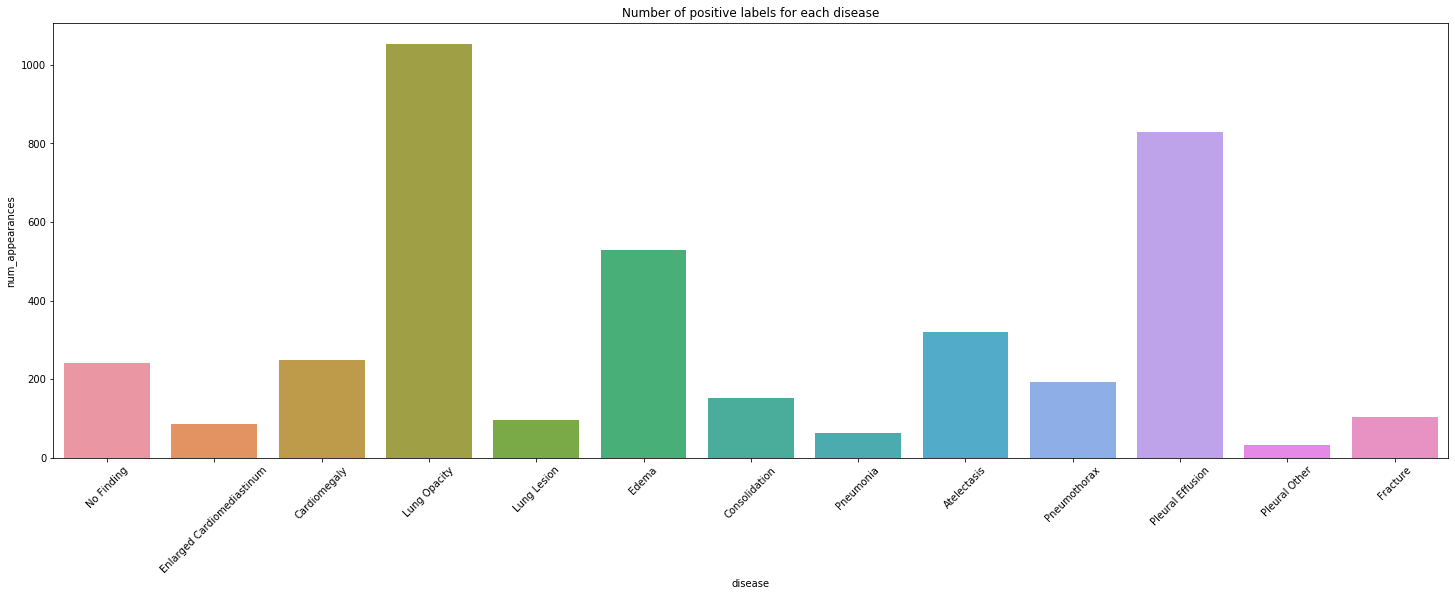

In [34]:
import seaborn as sns
disease_count = {}
for col in disease_cols:
    disease_count[col]=train_df[col].value_counts()[1] #gets count of those with 1
print(disease_count)


disease_count_df = pd.DataFrame(list(disease_count.items()),columns = ['disease','num_appearances']) 
plt.figure(figsize=(25,8))
ax=sns.barplot(x='disease', y='num_appearances', data=disease_count_df)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_title('Number of positive labels for each disease')
plt.savefig('disease_count_after.png')


### Dataset loader class
- Formatting labels/class for modeling
- Returns image, age, gender and label

In [35]:

I = np.eye(3) #for 3 class coding, positive, negative uncertain 

gender_map = {'Female': 0, 'Male': 1, 'Unknown': 2}
gender_tensor = torch.zeros(len(gender_map))

class CheXpertDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, ages, genders, transforms):
        '''
        
        labels: a list of lists with values 0, 1 or 2 for each of the 13 classes
        image_paths: list of the file paths to the image
        transforms: transoforms to use for the images for input into model
         
        '''
        self.labels = labels
        self.image_paths = image_paths
        self.age = ages
        self.gender = genders
        self.transform = transforms

        
    def __getitem__(self,idx):
        img_path = self.image_paths[idx]
 
        # read image
#use below to change the image to color w/out the repeat transform
        image = Image.open(img_path).convert('RGB')
 
        # get age
        age = self.age[idx]
        #get gender
        gender = self.gender[idx]
        
        if self.transform:
            image = self.transform(image)


        #one hot encode gender, then edit tensor
        gender = gender_map[gender]
        gender_tensor[gender] = 1
        gender = gender_tensor
        
        #normalize age
        age = torch.tensor((age-age_mean)/age_std)
        
        label = self.labels[idx]
        vec = np.array(label, dtype=int)
#         single vector to the one-hot encoding (3xlen(labels))
        out = I[vec].ravel()

        label = torch.from_numpy(out)
        
        #returning tuple because LRFinder expects one input. 
        #this will be unpacked in the model forward function
        return (image, age, gender), label
    
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.image_paths)        

### Pretrained Densenet



In [36]:
class DensNet(nn.Module):
    def __init__(self, out_dim=39, num_channels=1):
        super().__init__()
        preloaded = torchvision.models.densenet121(pretrained=True)
        self.features = preloaded.features
        del preloaded
        
        self.l1 = nn.Linear(4, 32, bias = True)
        self.l2 = nn.Linear(32, 16, bias = True) #go into last linear 
        
        self.classifier = nn.Linear(1024+16, out_dim, bias=True)
        
        
    def forward(self, x):

        image, age, gender = x
        features = self.features(image)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)

        
#         meta_out = self.l1(torch.cat([age.float().unsqueeze(-1), gender], 1))
#include singleton dimension along rows in case of 1 data point
        age_unsqueeze = age.float().unsqueeze(-1)
        if len(gender.shape) == 1:
            gender = gender.unsqueeze(0)
            age_unsqueeze = age_unsqueeze.unsqueeze(0)
        tens = torch.cat([age_unsqueeze, gender], 1)
        meta_out = self.l1(tens)
        meta_out = self.l2(meta_out)



        out = self.classifier(torch.cat([out,meta_out], dim=1))
        return out

In [37]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

### Weighted Focal loss


In [38]:
# from https://amaarora.github.io/2020/06/29/FocalLoss.html
# the code assumes binary classification.  Since I am doing multilabel - multiclass, need to flatten BCE_loss

class WeightedFocalLoss(nn.Module):
    "Non weighted version of Focal Loss"
    def __init__(self, alpha=.25, gamma=2):
        super(WeightedFocalLoss, self).__init__()
        self.alpha = torch.tensor([alpha, 1-alpha]).cuda()
        self.gamma = gamma

    # mean is the boolean to decide between returning the mean vs the whole vector of loss
    def forward(self, inputs, targets, mean=True):
#         print(f' size of inputs (should be batch size): {inputs.size()}')
#         print(f'size of targets: {targets.size()}')
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        BCE_loss = BCE_loss.view(-1).contiguous()
#         print(f'size of BCE loss: {BCE_loss.size()}')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1)).contiguous()
        pt = torch.exp(-BCE_loss)

        F_loss = at*(1-pt)**self.gamma * BCE_loss
        if mean:
            return F_loss.mean()
        else:
            return F_loss


### SKLearn for validation metrics

In [39]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, multilabel_confusion_matrix, \
accuracy_score, ConfusionMatrixDisplay, f1_score, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore", message="No negative samples in y_true, false positive value should be meaningless")
warnings.filterwarnings("ignore", message="No positive samples in y_true, true positive value should be meaningless")
#suppressing 
# This means that all the values in y_true are zeros or all ones, which means there is no positive class or neg class records in the given dataset.


classes = {0: 'Negative', 1: 'Positive', 2: 'Uncertain'}
def calc_val_metrics(gt, pred):
    conf_mat_dict={}
    fpr = {} #these will be dictionary of dictionaries for each disease to keep values for each class
    tpr = {}
    roc_auc = {}
    precision = {}
    recall = {}
    f1 = {}
    accuracy = {}
    
    gt = np.array(gt)
    pred = np.array(pred)
    # for d,disease in enumerate(disease_cols):
    for i,disease in zip(range(0,39,3), disease_cols): #travese every 3 digits
        
        y_true_label = gt[:, i:i+3] 
        y_pred_label = pred[:, i:i+3]
        conf_mat_dict[disease] = multilabel_confusion_matrix(y_pred=y_pred_label.argmax(axis=1), 
                                                             y_true=y_true_label.argmax(axis=1), labels=[0,1,2])
  
        fpr[disease] = {}
        tpr[disease] = {}
        roc_auc[disease] = {}
        precision[disease] = {}
        recall[disease] = {}
        f1[disease] = {}
        for col, label in enumerate(['Negative', 'Positive', 'Uncertain']):
            fpr[disease][label], tpr[disease][label], _ = roc_curve(y_true_label[:,col], (y_pred_label[:,col] >= 0.5).astype(np.float))
            
            try: #for when not perfect. hence auc is 1 
                roc_auc[disease][label] = roc_auc_score(y_true=y_true_label[:,col], y_score=y_pred_label[:,col])
            except ValueError:
                roc_auc[disease][label] = 1
        accuracy[disease] = accuracy_score(y_true_label.argmax(axis=1), y_pred_label.argmax(axis=1))
    lw = 4
    figsize = (20, 25)
    cols = 3
    rows = len(disease_cols) // cols + 1
    colors = ['aqua', 'darkorange', 'cornflowerblue']
    fig,ax = plt.subplots(rows, cols, figsize=figsize)
    axes = ax.flatten()
    
    for d_ix,disease in enumerate(disease_cols):
        for i, label in enumerate(['Negative', 'Positive', 'Uncertain']):
            if label in fpr[disease]:
                axes[d_ix].plot(fpr[disease][label], tpr[disease][label], color=colors[i], lw=lw,
         label=f'Class {classes[i]} (area = {roc_auc[disease][label]:0.2f})')
        axes[d_ix].plot([0, 1], [0, 1], 'k--', lw=lw)
        axes[d_ix].set_xlim([0.0, 1.0])
        axes[d_ix].set_ylim([0.0, 1.05])
        axes[d_ix].set_xlabel('False Positive Rate')
        axes[d_ix].set_ylabel('True Positive Rate')
        axes[d_ix].set_title(f'{disease} ROC Curve')
        axes[d_ix].legend(loc="lower right")
        
    return conf_mat_dict,fpr,tpr,roc_auc,accuracy, precision, recall, f1

In [40]:

# Parameters
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 4}

max_epochs = 30

train_transforms = transforms.Compose([
    transforms.CenterCrop(320),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5330], std=[0.0349]) ])#,                             # whiten with dataset mean and std

training_set = CheXpertDataset(train_paths, train_labels, train_ages, train_genders, train_transforms)
training_generator = torch.utils.data.DataLoader(training_set, **params)

#for now train and valid transforms can be the same
valid_transforms = train_transforms
validation_set = CheXpertDataset(valid_paths, valid_labels, valid_ages, valid_genders, valid_transforms)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [41]:
# to load model weights

MODEL_PATH = 'checkpoint_meta4.pt'
model = DensNet()
model.load_state_dict(torch.load(MODEL_PATH))

model.to(device)


last_lin_layers = ['classifier.weight', 'classifier.bias']

d16_covnets = ['features.denseblock4.denselayer16.conv2.weight', 'features.denseblock4.denselayer16.conv1.weight']
d15_covnets = ['features.denseblock4.denselayer15.conv1.weight','features.denseblock4.denselayer15.conv2.weight']

# requires_grad = True #for layers to unfreeze
    
for name, param in model.named_parameters():
#     if param.requires_grad == True:
#     print(name)#, param.data)
    if name in last_lin_layers +d16_covnets : #+ d15_covnets:
        print(name)
        param.requires_grad = True
    else:
        param.requires_grad = False
        


features.denseblock4.denselayer16.conv1.weight
features.denseblock4.denselayer16.conv2.weight
classifier.weight
classifier.bias


In [42]:
# sanity check
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(name)#, param.data)

features.denseblock4.denselayer16.conv1.weight
features.denseblock4.denselayer16.conv2.weight
classifier.weight
classifier.bias


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.71E-05


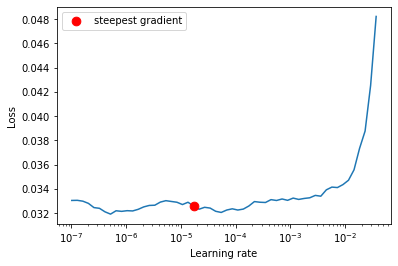

In [43]:
# source https://github.com/davidtvs/pytorch-lr-finder
from torch_lr_finder import LRFinder
learning_rate = 1e-8
betas = (0.9, 0.999)
weight_decay = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                             betas=betas, weight_decay = weight_decay)

loss_fn = WeightedFocalLoss()
lr_finder = LRFinder(model, optimizer, loss_fn, device="cuda")
lr_finder.range_test(training_generator, end_lr=100, num_iter=100)#, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() #

In [44]:
def save_checkpoint(val_loss, val_loss_min, model, path, verbose=True):
    '''Saves model when validation loss decrease.'''
    if verbose:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save(model.state_dict(), path)

In [45]:
#suggested by LRFinder, fast.ai way
learning_rate = 5.34E-06
betas = (0.9, 0.999)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, 
                             betas=betas, weight_decay = weight_decay)
loss_fn = WeightedFocalLoss()
         
params["train_transforms"] = str(train_transforms)
params["val_transforms"] = str(valid_transforms)
params['lr'] = learning_rate
params.update({ 'betas':betas,'epochs':max_epochs,'weight_decay':weight_decay})
                             

In [46]:
#pass the dictionary of parameters to neptune for experiment tracking
if NEPTUNE_TRACK:
    neptune.create_experiment('pytorch-densenet121_meta_wloss_frozen',params=params)

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 0/29


  1%|          | 1/104 [00:00<01:00,  1.71it/s]

Batch Loss 1/104: 0.034


100%|██████████| 104/104 [00:28<00:00,  3.59it/s]

Train Loss: 0.033


validation batch Loss 1/8: 0.032
Val Loss: 0.004
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.7%, Avg loss: 0.004390 



  0%|          | 0/104 [00:00<?, ?it/s]

Validation loss decreased (inf --> 0.004390).  Saving model ...
Epoch 1/29


  1%|          | 1/104 [00:00<00:46,  2.24it/s]

Batch Loss 1/104: 0.034


100%|██████████| 104/104 [00:22<00:00,  4.69it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.038
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.005062 



  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 2/29


  1%|          | 1/104 [00:00<00:46,  2.21it/s]

Batch Loss 1/104: 0.035


100%|██████████| 104/104 [00:22<00:00,  4.69it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.034
Val Loss: 0.004
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.004140 



  0%|          | 0/104 [00:00<?, ?it/s]

Validation loss decreased (0.004390 --> 0.004140).  Saving model ...
Epoch 3/29


  1%|          | 1/104 [00:00<00:47,  2.19it/s]

Batch Loss 1/104: 0.034


100%|██████████| 104/104 [00:22<00:00,  4.68it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.036
Val Loss: 0.006
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.005560 



  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 4/29


  1%|          | 1/104 [00:00<00:48,  2.13it/s]

Batch Loss 1/104: 0.035


100%|██████████| 104/104 [00:22<00:00,  4.70it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.033
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.004520 



  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 5/29


  1%|          | 1/104 [00:00<00:45,  2.25it/s]

Batch Loss 1/104: 0.031


100%|██████████| 104/104 [00:22<00:00,  4.70it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.035
Val Loss: 0.004
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.004320 



  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 6/29


  1%|          | 1/104 [00:00<00:45,  2.25it/s]

Batch Loss 1/104: 0.033


100%|██████████| 104/104 [00:22<00:00,  4.70it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.038
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.005029 



  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 7/29


  1%|          | 1/104 [00:00<00:45,  2.24it/s]

Batch Loss 1/104: 0.032


100%|██████████| 104/104 [00:22<00:00,  4.69it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.031
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.004934 



  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 8/29


  1%|          | 1/104 [00:00<00:48,  2.11it/s]

Batch Loss 1/104: 0.032


100%|██████████| 104/104 [00:22<00:00,  4.70it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.028
Val Loss: 0.004
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.004398 



  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 9/29


  1%|          | 1/104 [00:00<00:46,  2.22it/s]

Batch Loss 1/104: 0.032


100%|██████████| 104/104 [00:22<00:00,  4.72it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.025
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.005385 



  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 10/29


  1%|          | 1/104 [00:00<00:48,  2.11it/s]

Batch Loss 1/104: 0.033


100%|██████████| 104/104 [00:22<00:00,  4.72it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.033
Val Loss: 0.006
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.9%, Avg loss: 0.006239 



  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 11/29


  1%|          | 1/104 [00:00<00:47,  2.16it/s]

Batch Loss 1/104: 0.031


100%|██████████| 104/104 [00:22<00:00,  4.71it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.032
Val Loss: 0.005
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 87.1%, Avg loss: 0.004856 



  0%|          | 0/104 [00:00<?, ?it/s]

Epoch 12/29


  1%|          | 1/104 [00:00<00:46,  2.23it/s]

Batch Loss 1/104: 0.029


100%|██████████| 104/104 [00:22<00:00,  4.72it/s]

Train Loss: 0.032


validation batch Loss 1/8: 0.034
Val Loss: 0.004
total count:504, size of matrix 121x39
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.004255 

Early stopping!


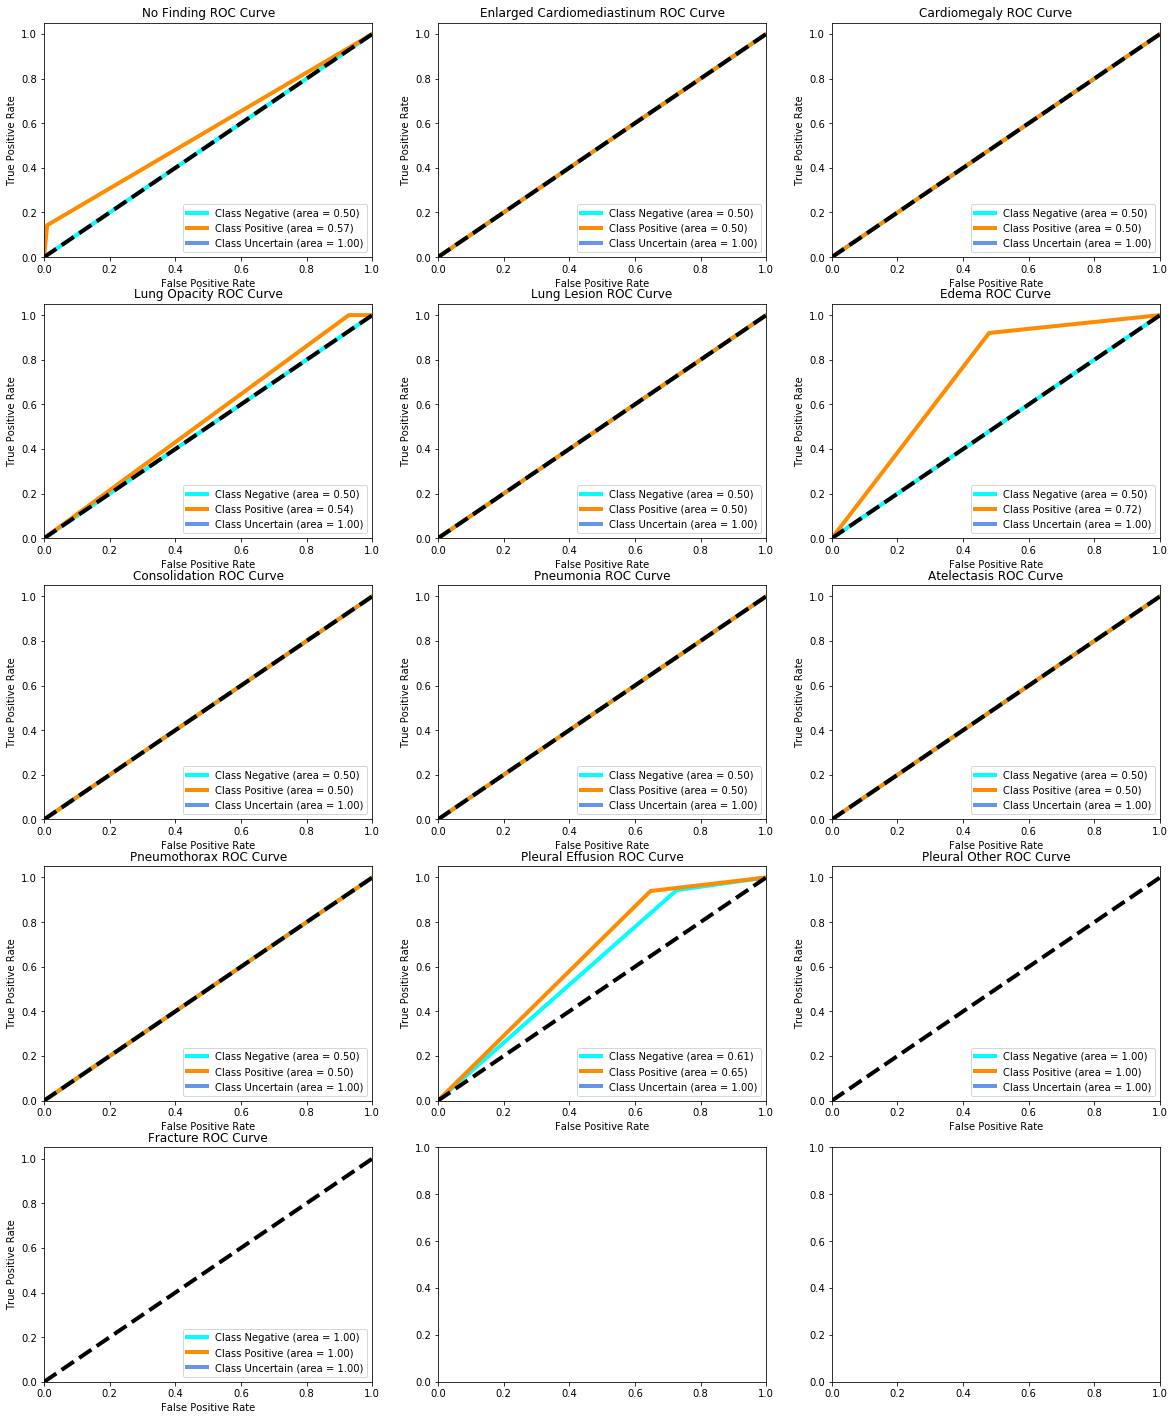

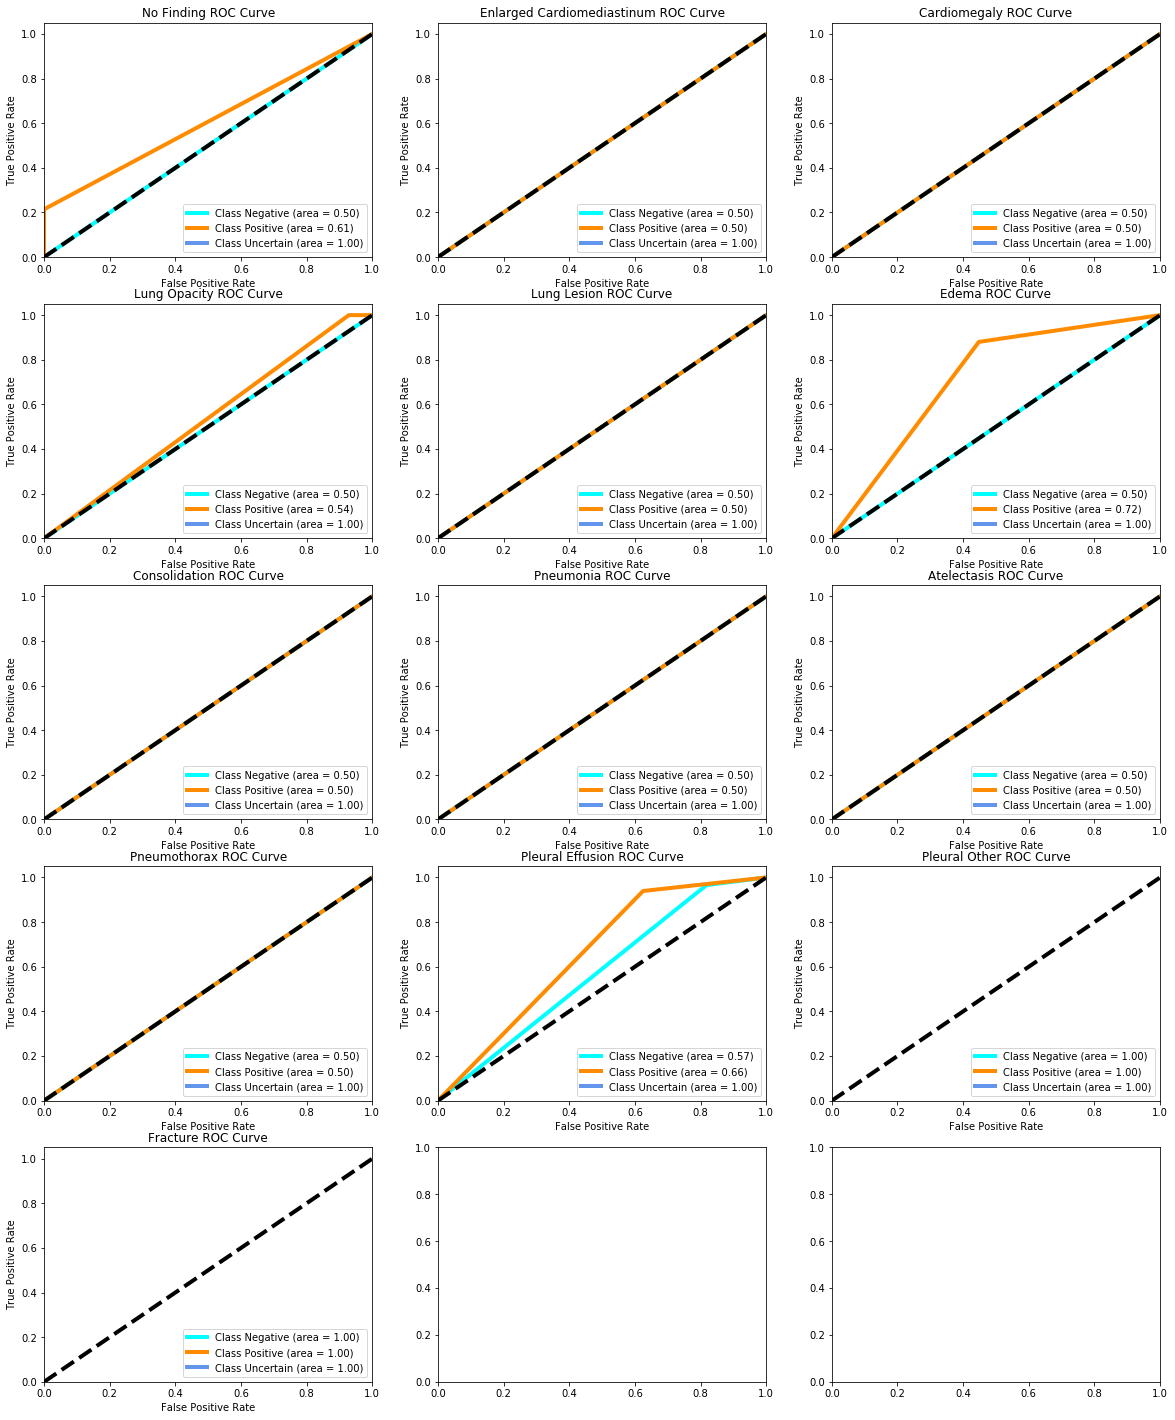

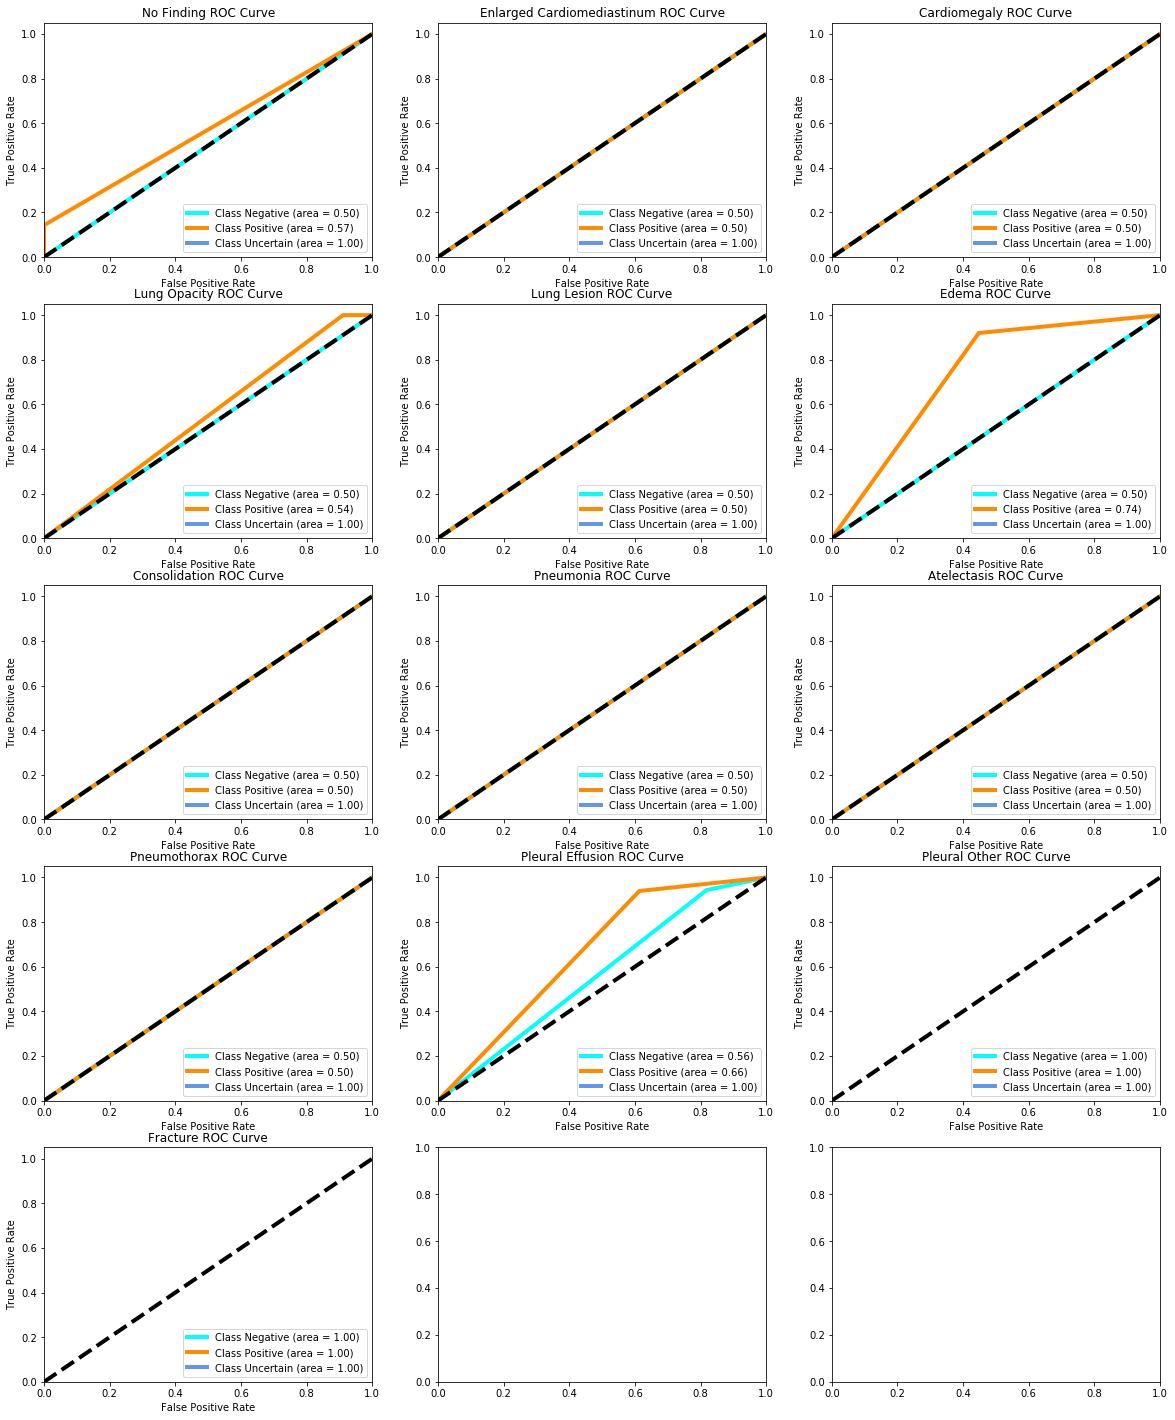

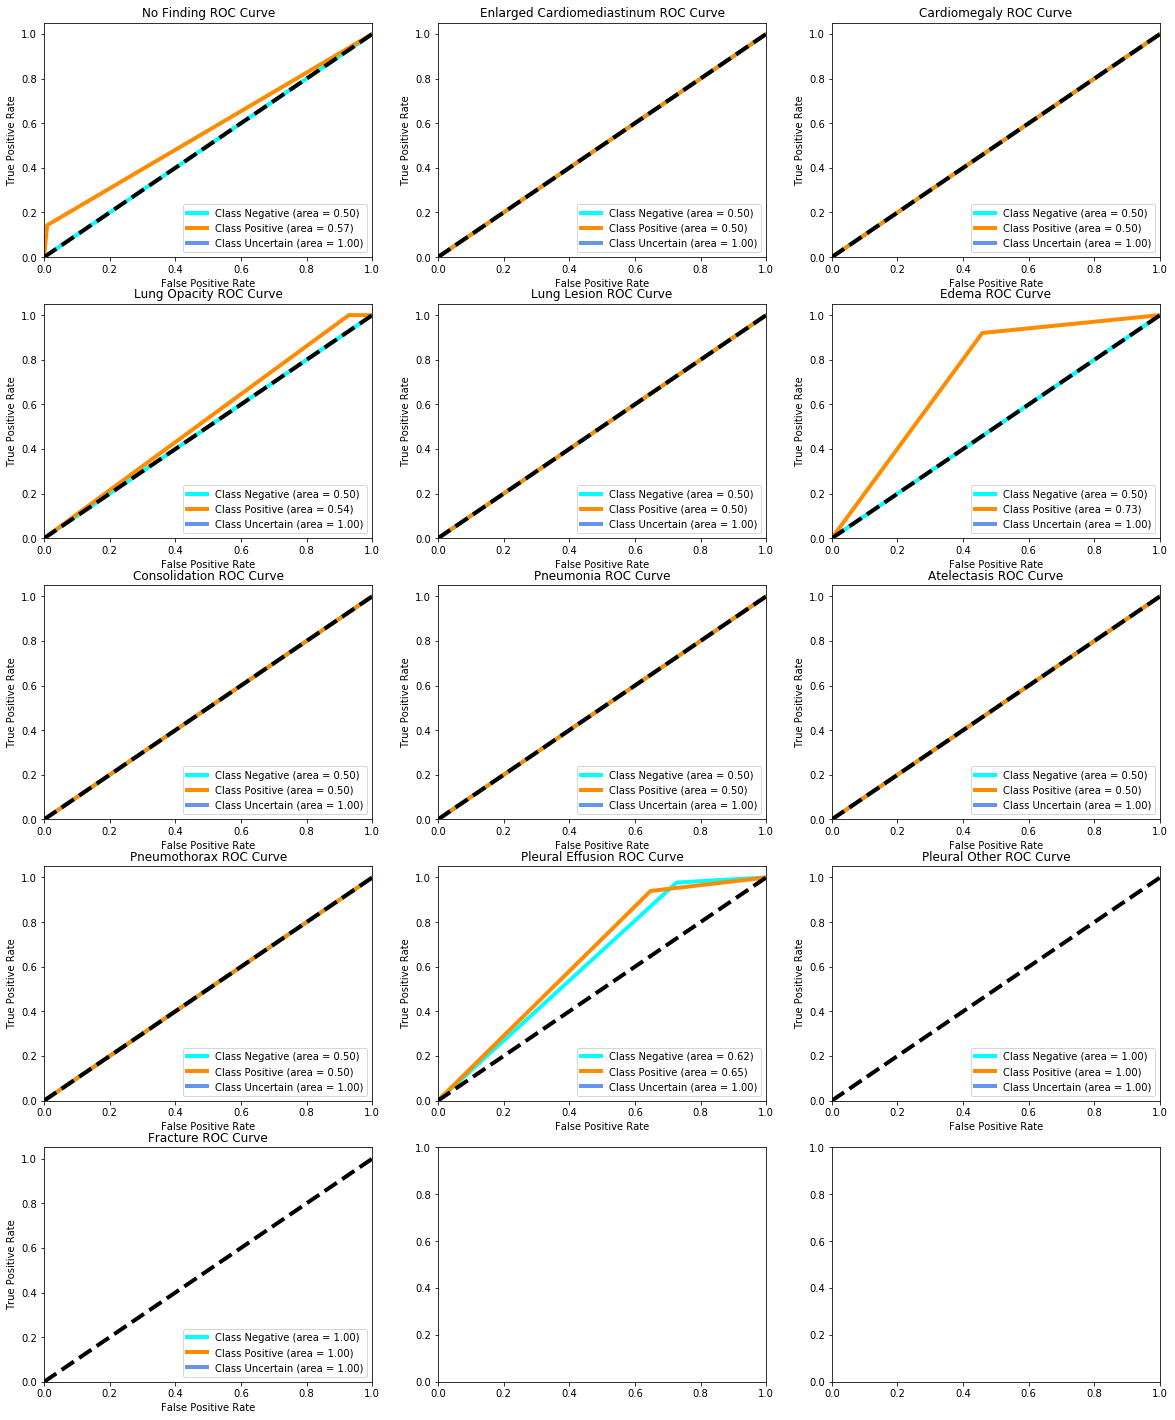

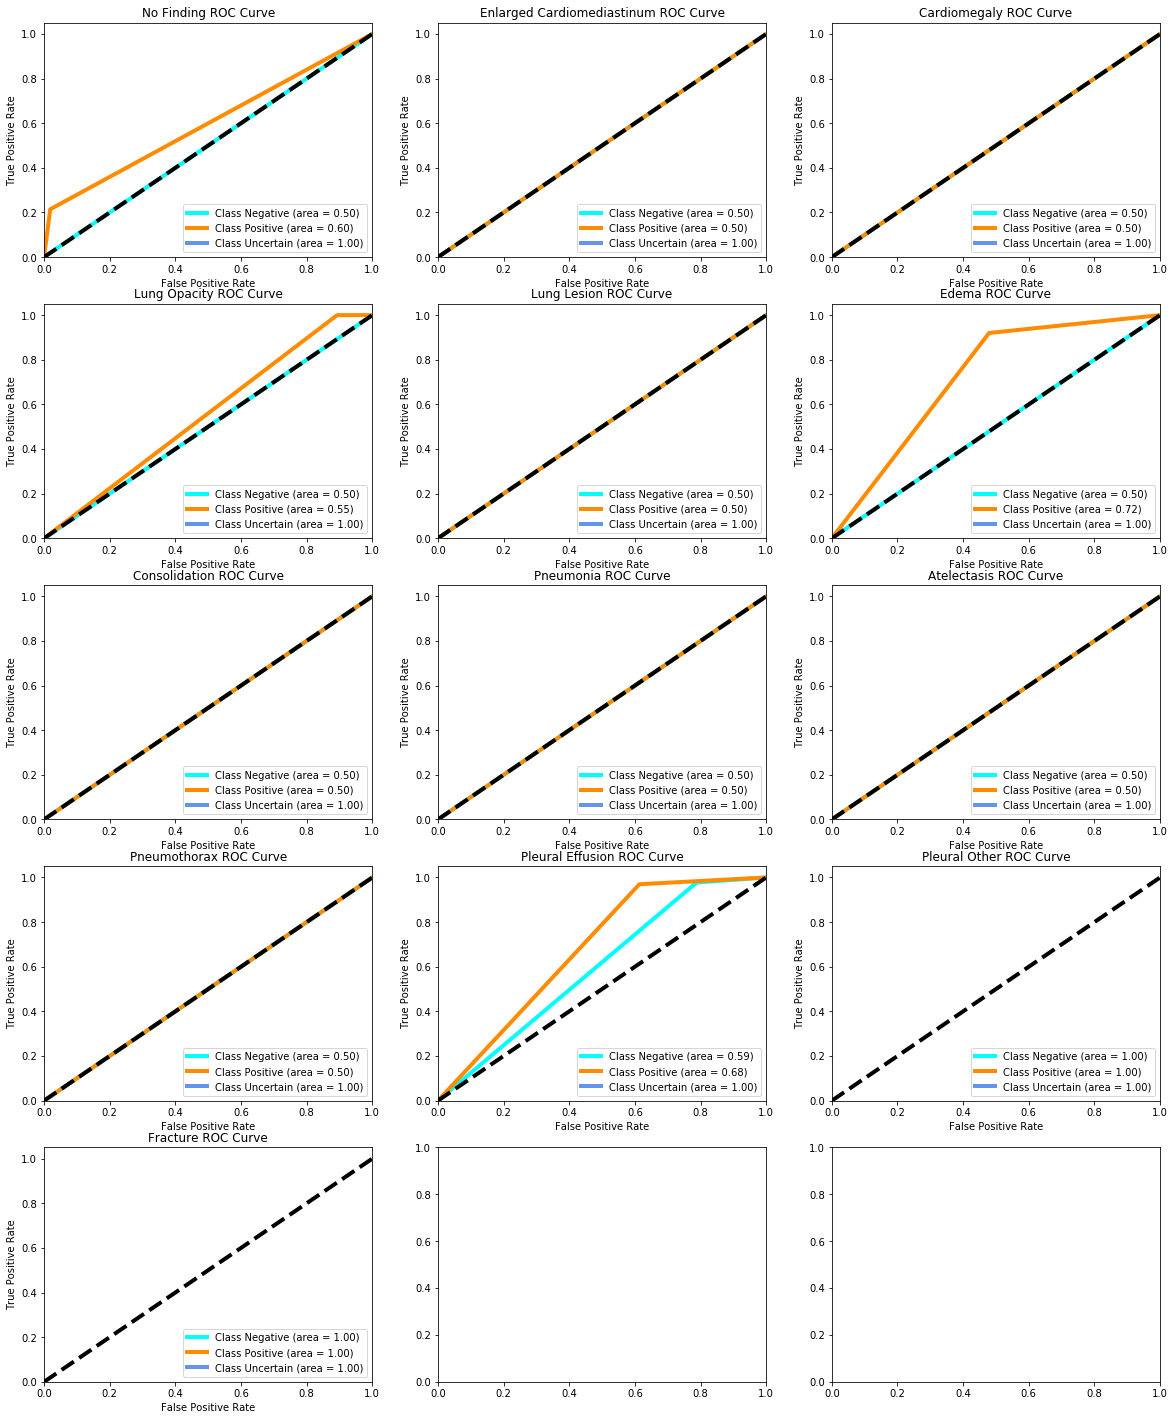

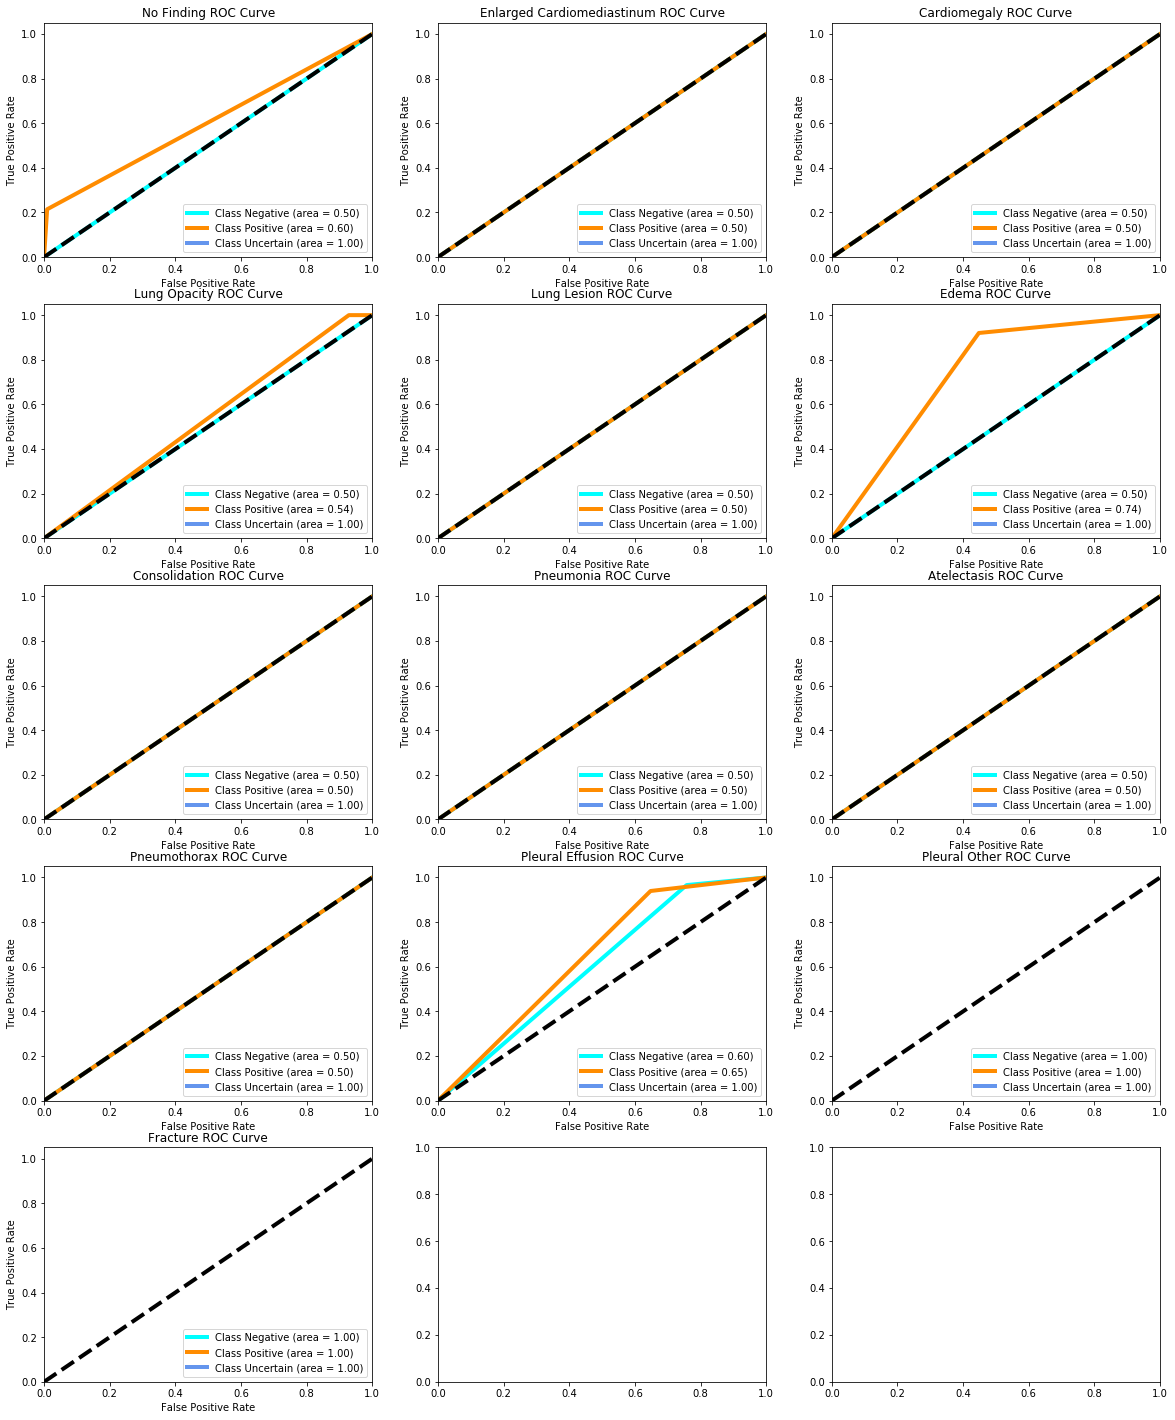

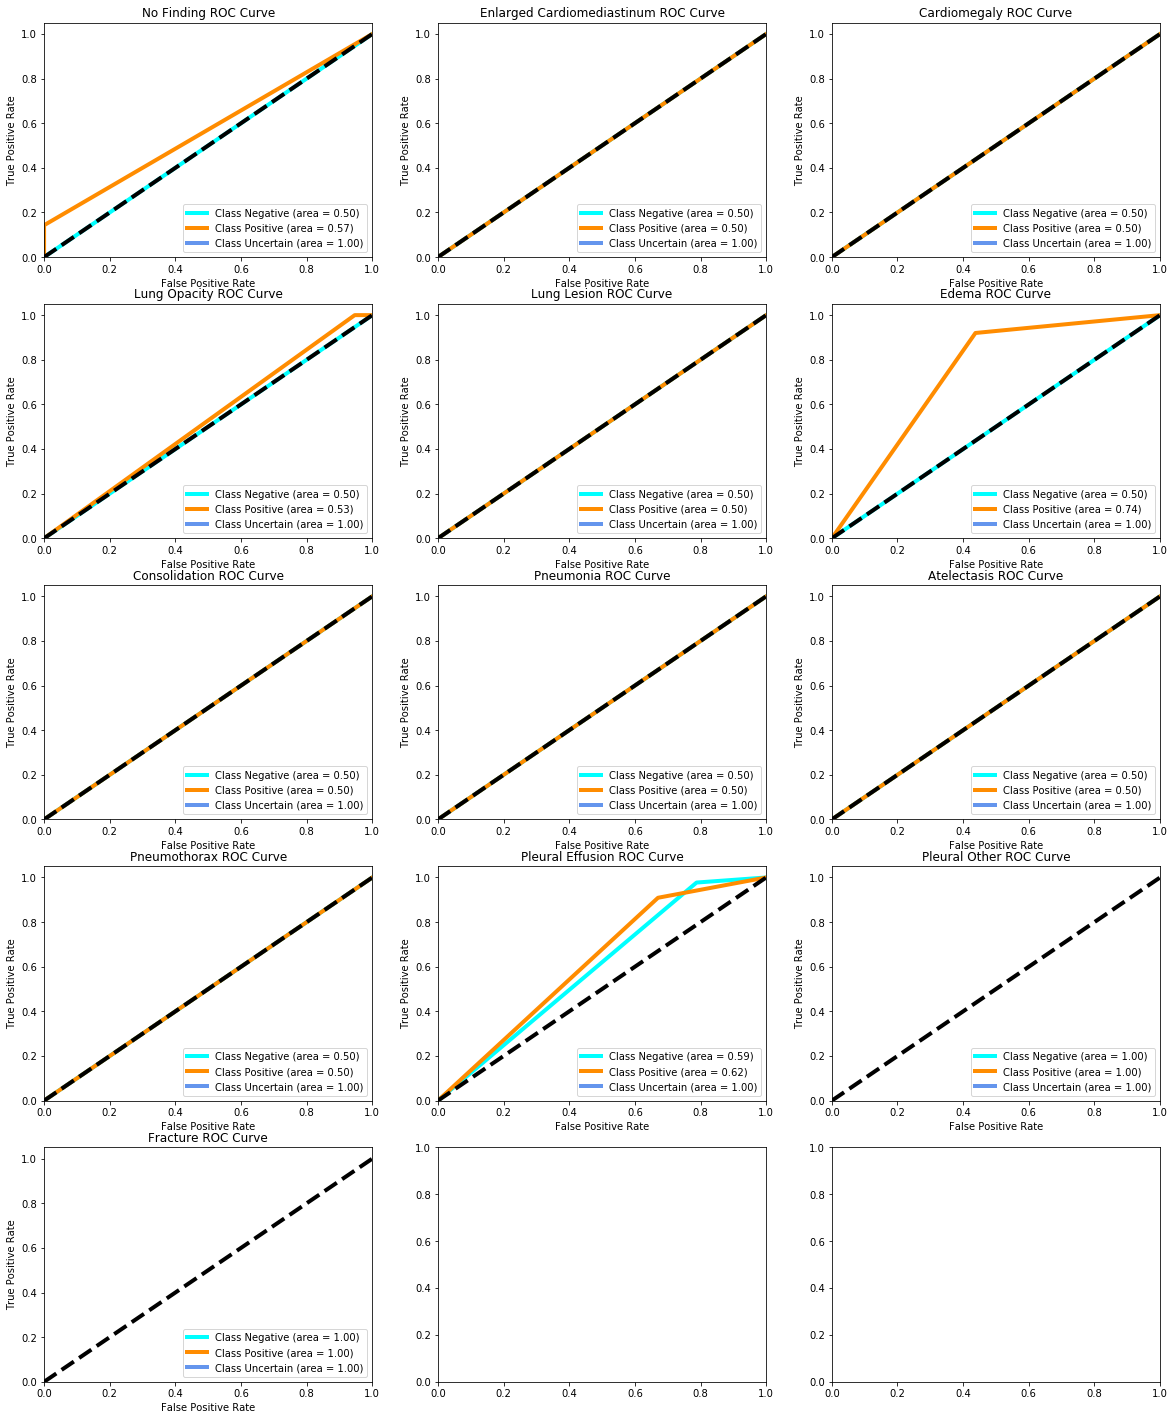

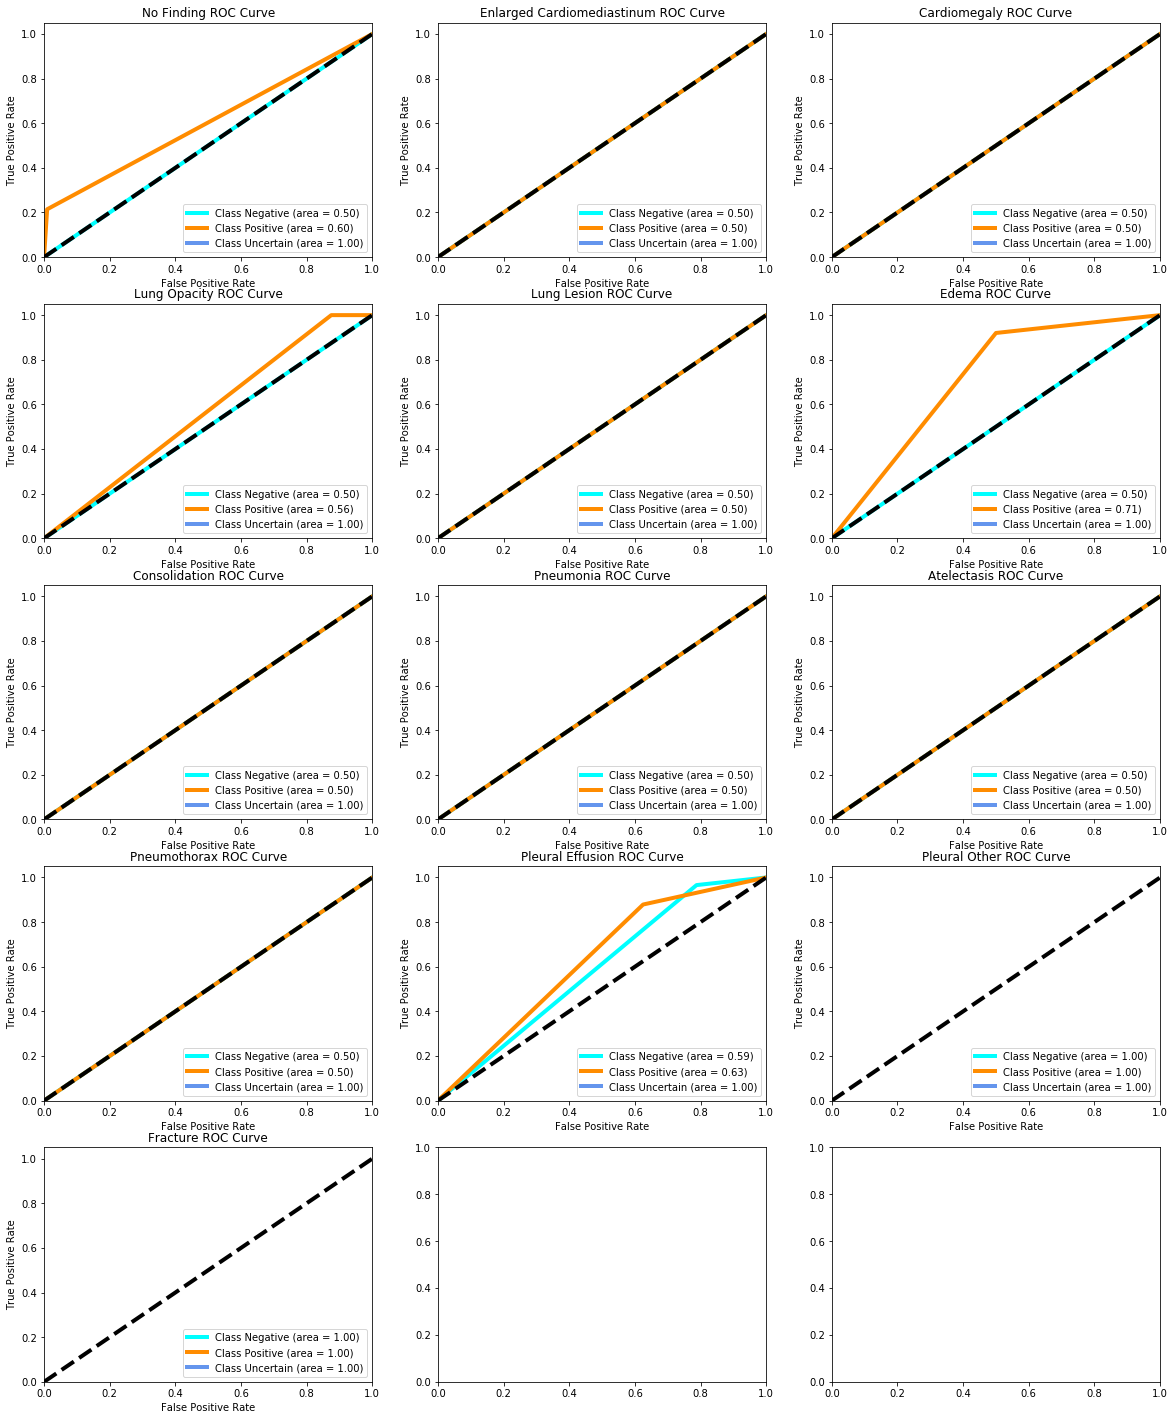

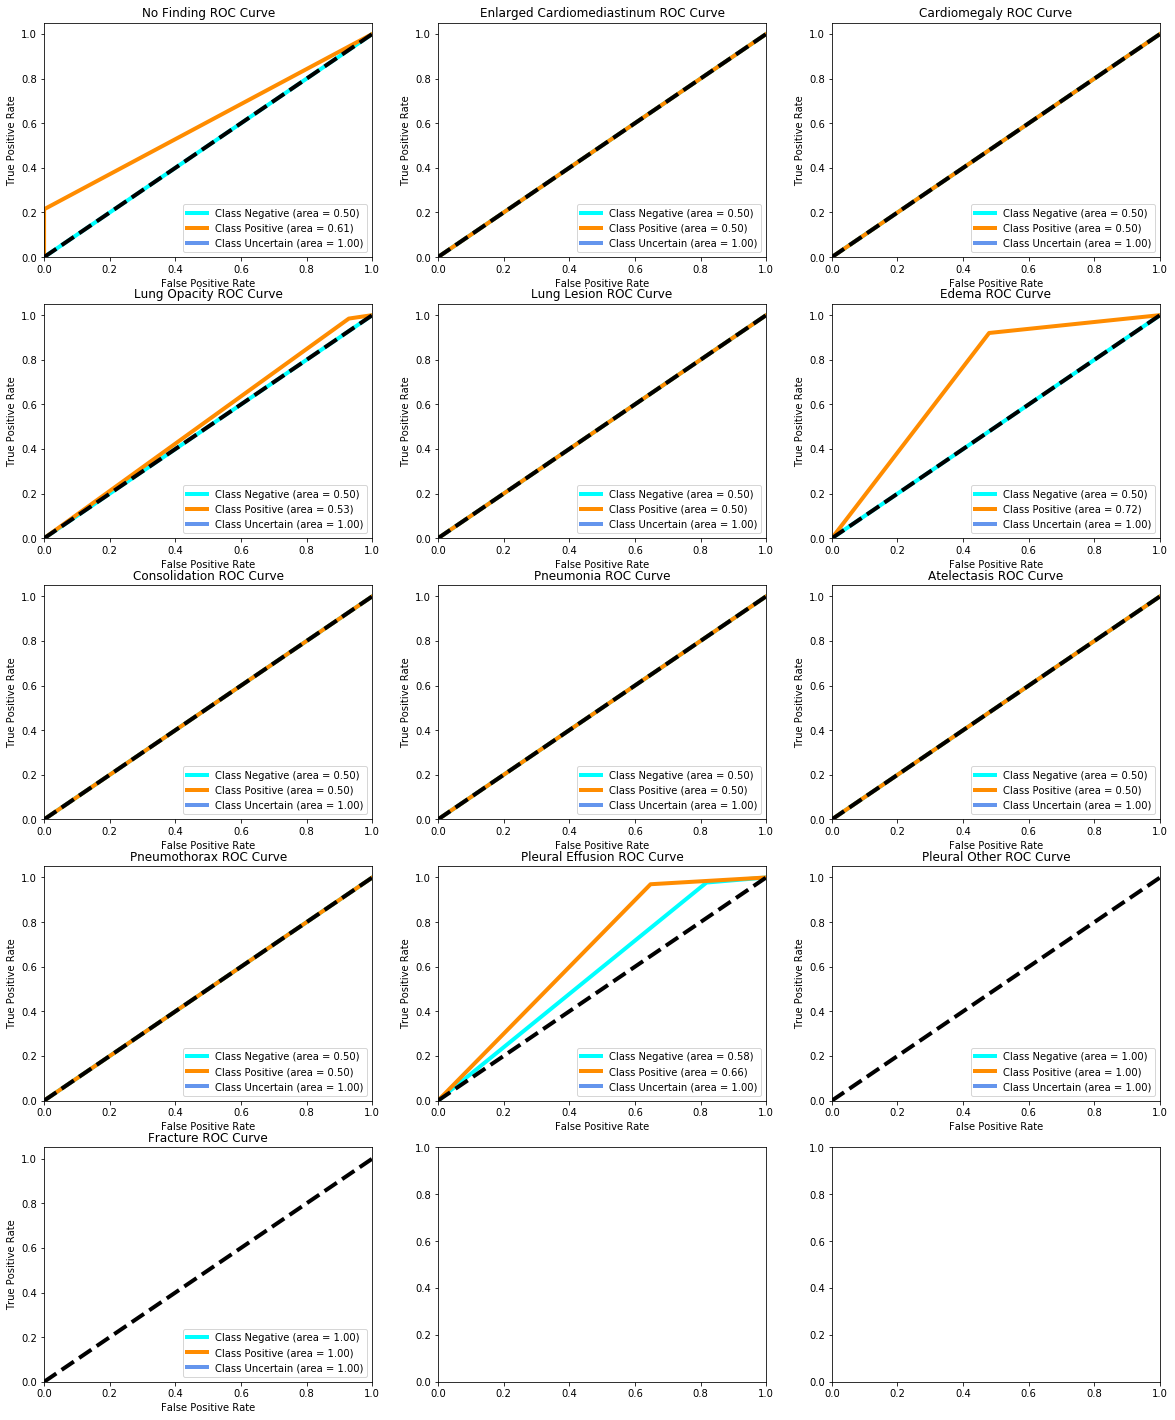

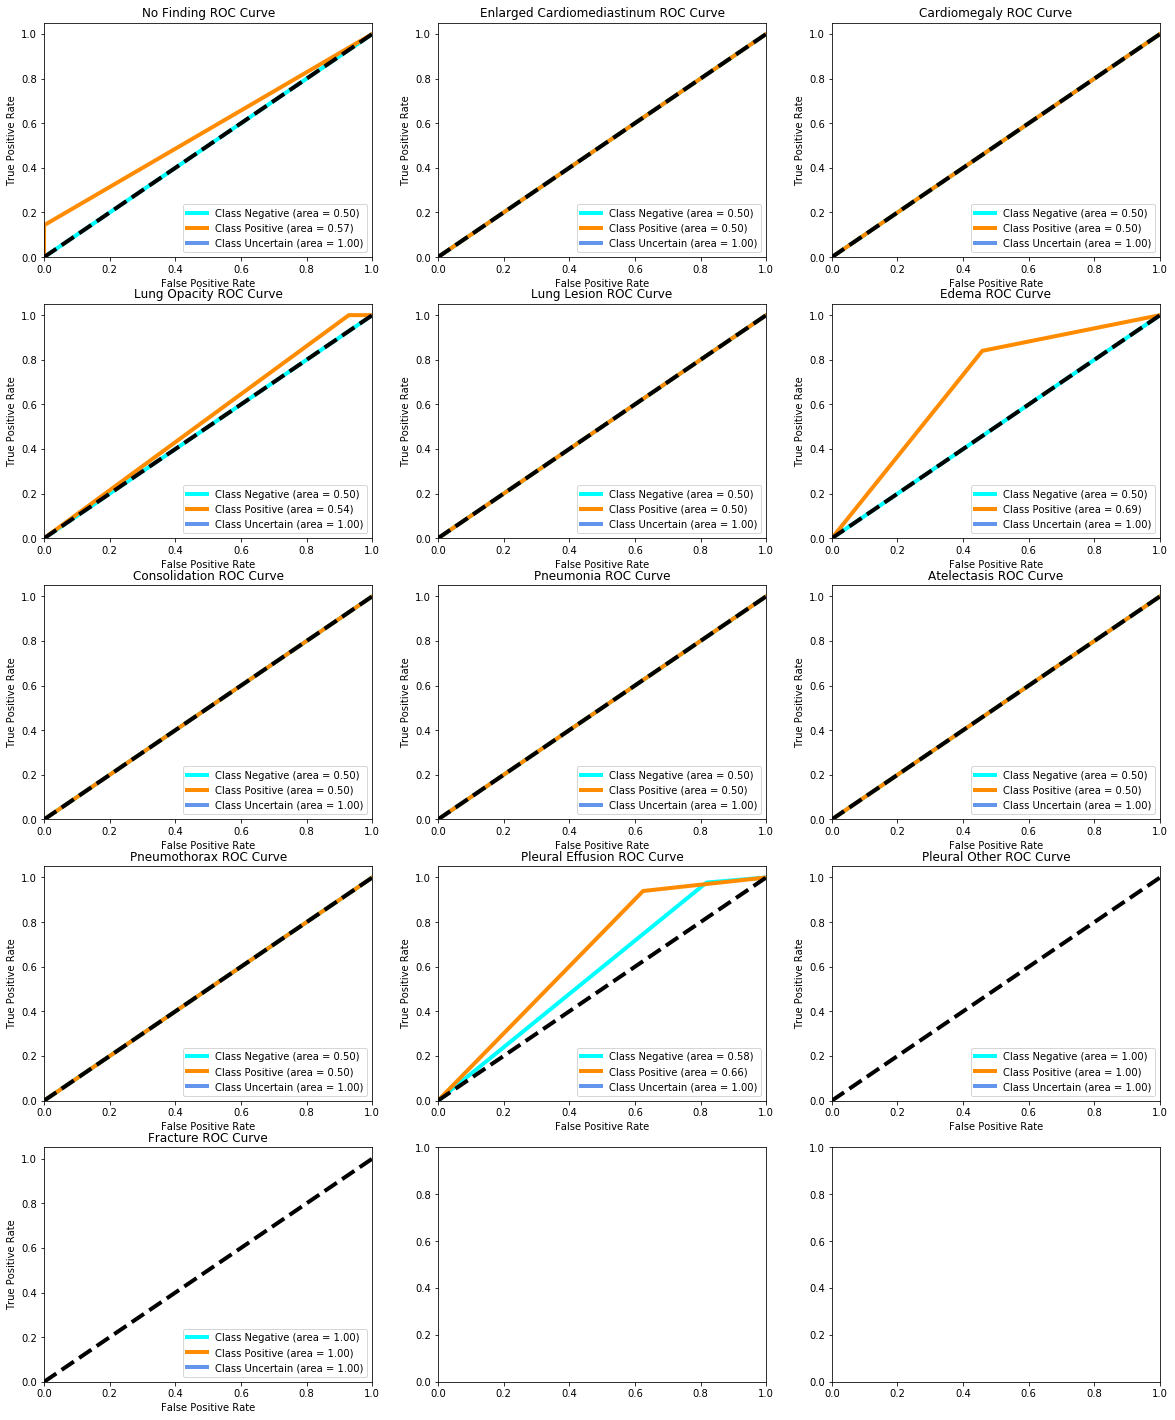

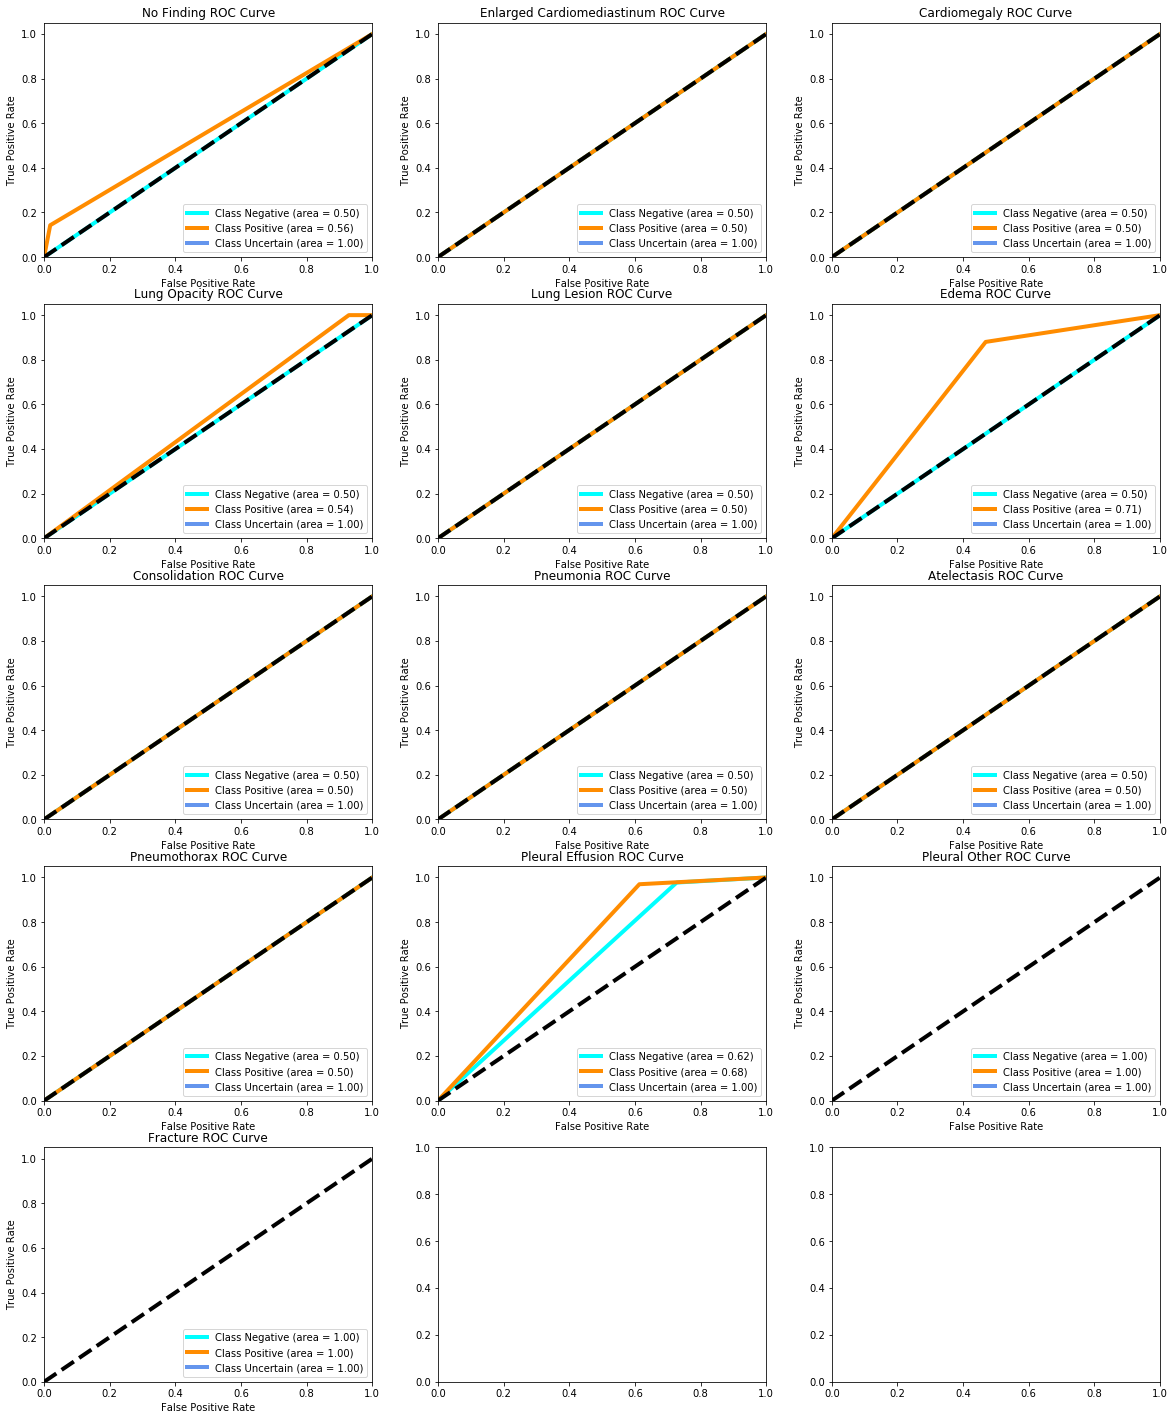

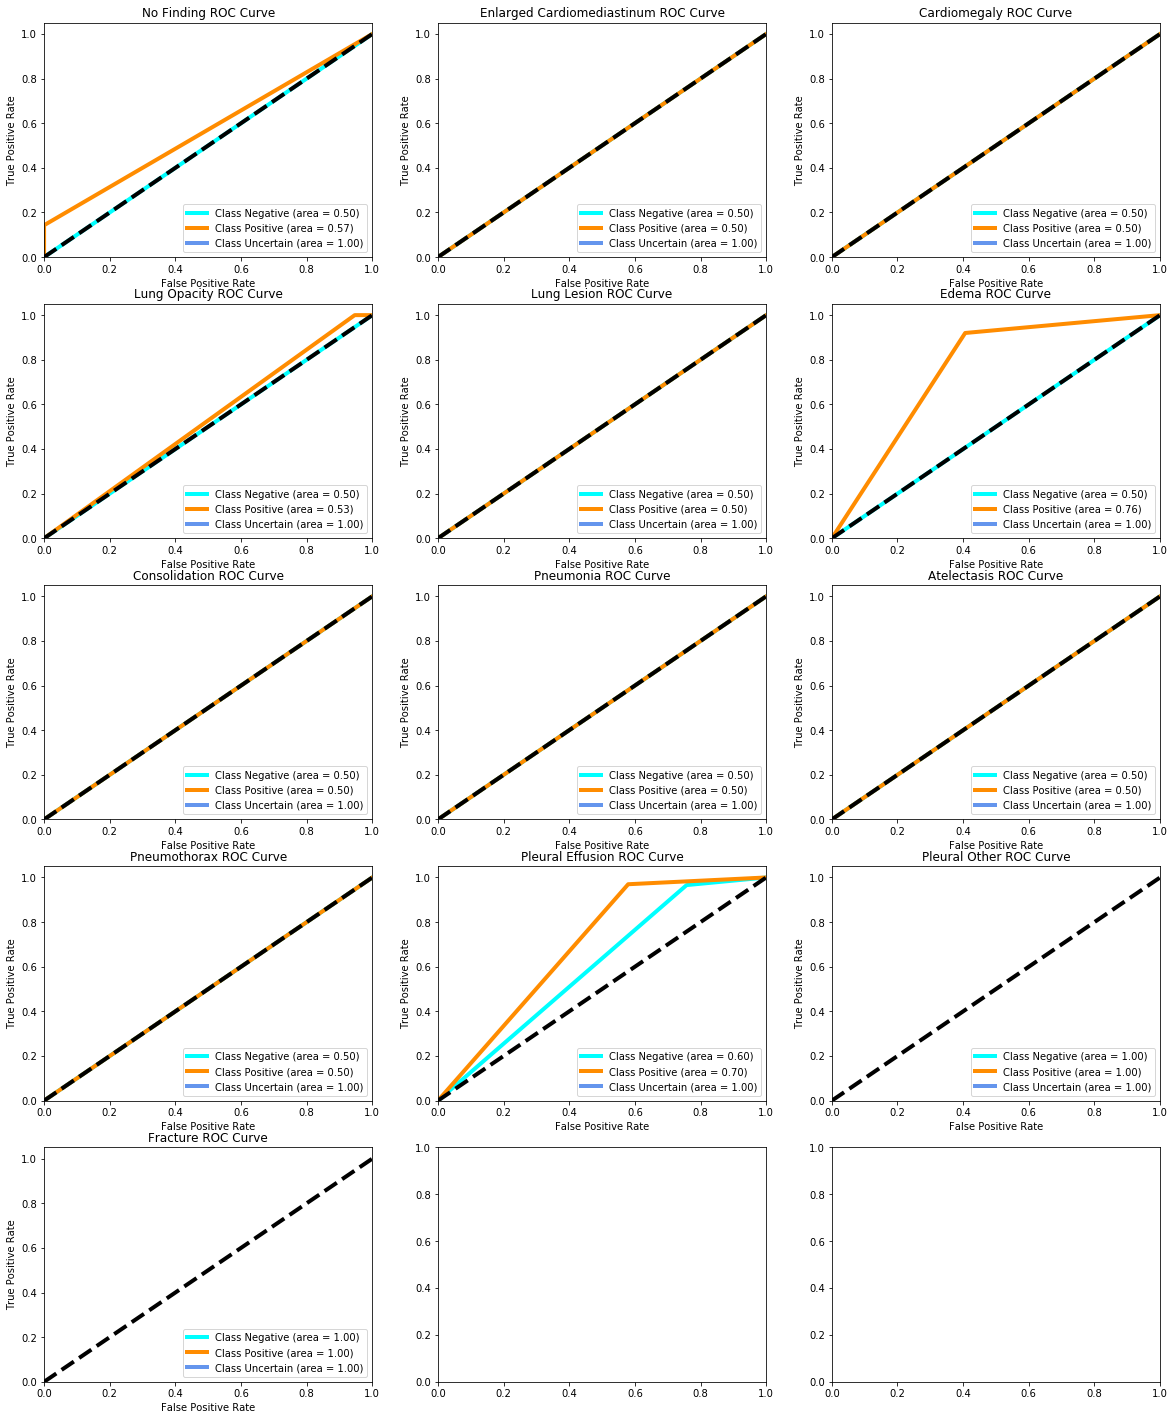

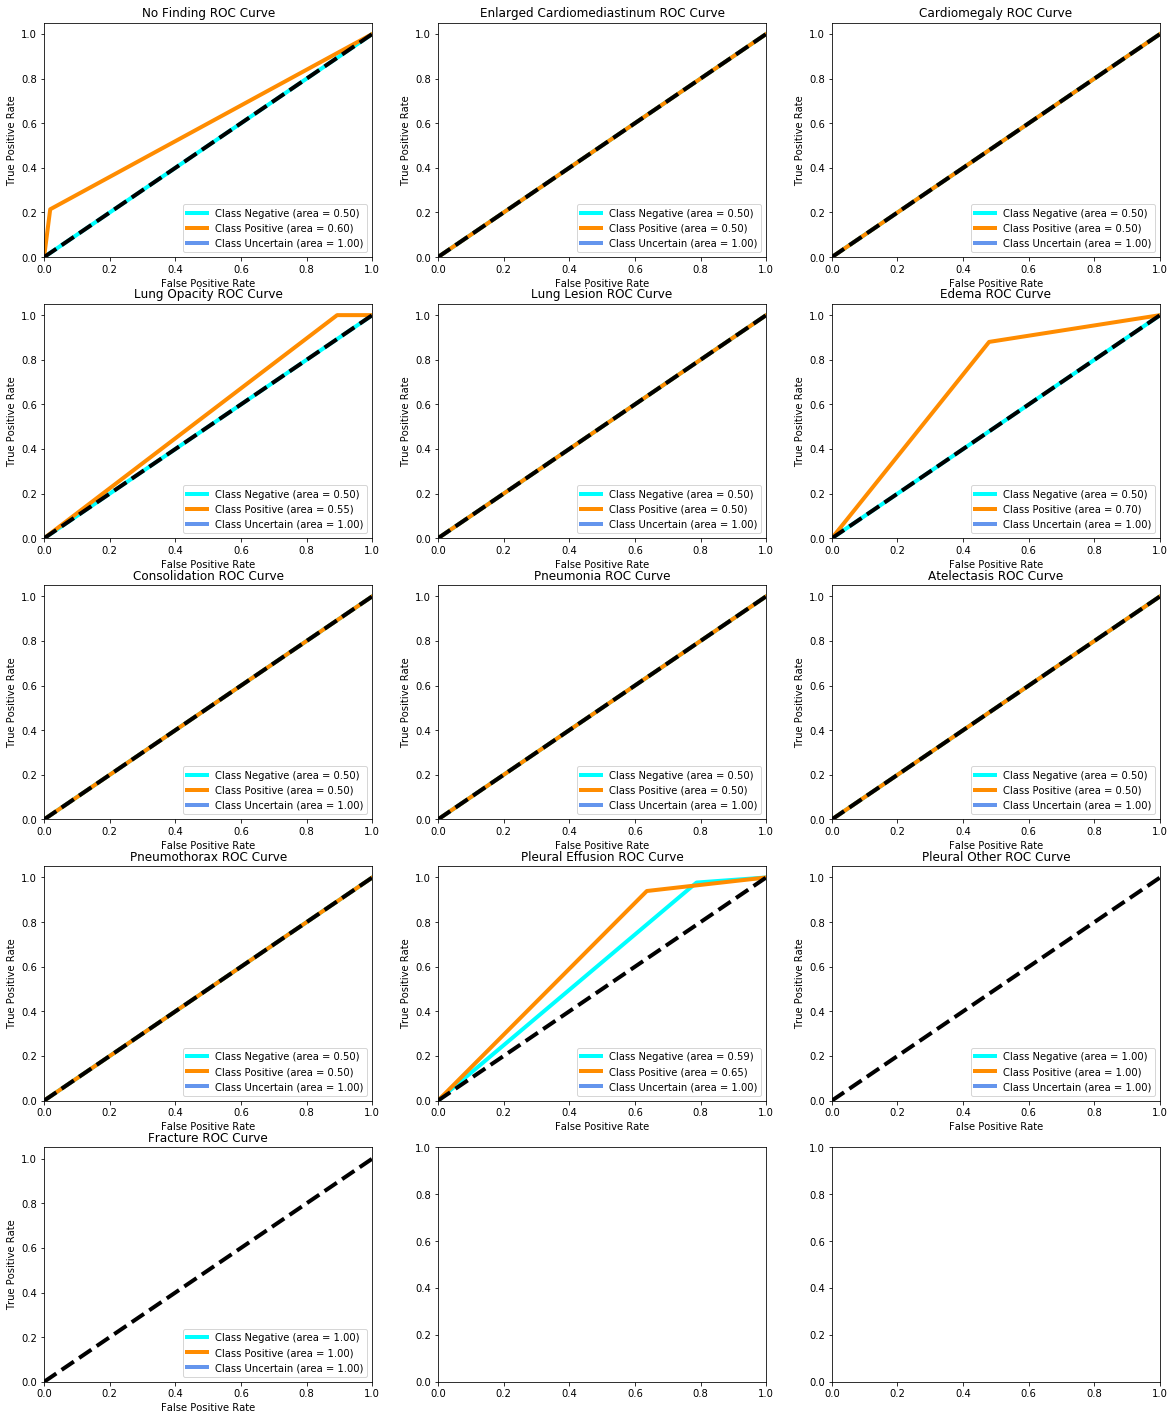

In [47]:
from tqdm import tqdm
import pickle

n_every = 1500
n_val_every = 100
avg_loss_list = []


n_epochs_stop = 10
epochs_no_improve = 0
early_stop = False
min_val_loss = np.Inf
iter = 0

neptune_num = '53'

#these will save the validation metric results for each epoch, Then can use them for plotting, analysis etc.
conf_mat_dict_list, fpr_list, tpr_list, roc_auc_list, accuracy_list, precision_list, recall_list, f1_list = [], [] ,[] ,[] ,[], [], [], []

for epoch in range(max_epochs):
    print('Epoch {}/{}'.format(epoch, max_epochs-1))
    # Training
    avg_loss = 0
    # Training

    for idx, (data,local_labels) in enumerate(tqdm(training_generator, total=len(training_generator))):
        local_batch, ages, genders = data
        # Transfer to GPU
        local_batch, local_labels, ages, genders = local_batch.to(device), local_labels.to(device), ages.to(device), genders.to(device)
        outputs = model((local_batch, ages, genders))

        
        loss = loss_fn(outputs, local_labels)
#         loss = criterion(outputs, local_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
        
        if NEPTUNE_TRACK:
            neptune.log_metric('train_batch_loss', loss)
        
        if idx % n_every == 0:
            print('Batch Loss {}/{}: {:.3f}'.format(idx + 1, len(training_generator), loss))
    avg_loss /= len(training_generator)
    avg_loss_list.append(avg_loss)
    print('Train Loss: {:.3f}'.format(avg_loss))
    
    if NEPTUNE_TRACK:
        neptune.log_metric('train_loss', avg_loss)

    # Validation
    with torch.set_grad_enabled(False):
        avg_loss = 0
        accuracy = 0
        val_count = 0
        vec_loss_list = []
        pred_matrix = [] #use these to collect all the pred and gt for eval, after each epoch for now
        gt_matrix = []
        
        for idx, (data,local_labels) in enumerate(validation_generator):
            local_batch, ages, genders = data
            
#             # Transfer to GPU
#             local_batch, local_labels = local_batch.to(device), local_labels.to(device)
            local_batch, local_labels, ages, genders = local_batch.to(device), local_labels.to(device), ages.to(device), genders.to(device)
            outputs = model((local_batch, ages, genders))
            loss = loss_fn(outputs, local_labels)
            avg_loss += loss.item()

            vec_loss = loss_fn(outputs, local_labels, mean=False)

            if idx % n_val_every == 0:
                print('validation batch Loss {}/{}: {:.3f}'.format(idx + 1, len(validation_generator), loss))
            
            if NEPTUNE_TRACK:
                neptune.log_metric('val_batch_loss', loss)
            
            
            avg_loss /= len(validation_generator)
            avg_loss_list.append(avg_loss)
            


            outputs = torch.sigmoid(outputs)

# take arg max of both the output matrix and ground truth reshaped matrix. 
            outputs = outputs.cpu().numpy()

            local_labels = local_labels.cpu().numpy()
            
            outputs_binary = np.select([outputs <= .5, outputs>.5], [np.zeros_like(outputs), np.ones_like(outputs)])
            
            #fix this or dont use it. its adding how many 0 and 1s match the GT
            accuracy += np.sum(outputs_binary == local_labels)
            val_count += len(validation_generator)+params['batch_size']+39
            pred_matrix.extend(outputs_binary)
            gt_matrix.extend(local_labels)
        
    print('Val Loss: {:.3f}'.format(avg_loss))

    accuracy /= len(validation_set)*39
    print(f"total count:{val_count}, size of matrix {len(pred_matrix)}x{len(pred_matrix[0])}")
    print(f"Test Error: \n Accuracy: {(100*accuracy):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

    #save metric dictionary of dictionaries for each epoch
    conf_mat_dict,fpr,tpr,roc_auc,accuracy,precision, recall, f1 = calc_val_metrics(gt_matrix, pred_matrix)
    
    conf_mat_dict_list.append(conf_mat_dict)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)
    accuracy_list.append(accuracy)
    precision_list.append(precision) 
    recall_list.append(recall) 
    f1_list.append(f1)
    
    if NEPTUNE_TRACK:
        neptune.log_metric('validation_loss', avg_loss)

                # If the validation loss is at a minimum
    if avg_loss < min_val_loss:
        save_checkpoint(avg_loss, min_val_loss, model, 'checkpoint_meta4.pt', True)
        epochs_no_improve = 0
        min_val_loss = avg_loss
        
        #save metrics for the checkpoint
        with open(f'val_metrics_c{neptune_num}_Train3.pkl', 'wb') as f:
            pickle.dump(conf_mat_dict_list,f)
            pickle.dump(fpr_list,f)
            pickle.dump(tpr_list,f)
            pickle.dump(roc_auc_list,f) 
            pickle.dump(accuracy_list,f)
            pickle.dump(precision_list,f)
            pickle.dump(recall_list,f)
            pickle.dump(f1_list,f)

    else:
        epochs_no_improve += 1
    iter += 1
    if epoch > 5 and epochs_no_improve == n_epochs_stop:
        print('Early stopping!' )
        early_stop = True
        break
    else:
        continue
            
    if early_stop:
        print("Stopped-saving model and metrics")
        break
        
#conf_mat_dict_list, fpr_list, tpr_list, roc_auc_list, accuracy_list saved as pickle files

PATH = f'thirty_epoch_chex-{neptune_num}.pth'
torch.save(model.state_dict(), 'state_dict_' + PATH)
torch.save(model, PATH)

with open(f'val_metrics_{neptune_num}.pkl', 'wb') as f:
        pickle.dump(conf_mat_dict_list,f)
        pickle.dump(fpr_list,f)
        pickle.dump(tpr_list,f)
        pickle.dump(roc_auc_list,f) 
        pickle.dump(accuracy_list,f)
        pickle.dump(precision_list,f)
        pickle.dump(recall_list,f)
        pickle.dump(f1_list,f)        
 


### Inference Function

takes in an image location

 `out.reshape((13, 3))` and each row will give you the probability of negative, positive and no finding for each class



In [57]:
# # if starting the notebook loading the model weights, use the below
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
import torchvision
from PIL import Image

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
# load model weights
# MODEL_PATH = 'ten_epoch_chex-26.pth'
MODEL_PATH = 'checkpoint_meta4.pt'
model = DensNet()
model.load_state_dict(torch.load(MODEL_PATH))

# model = torch.load(MODEL_PATH)
model.to(device)

model.eval()

img_transforms = transforms.Compose([
    transforms.CenterCrop(320),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5330], std=[0.0349]) ])#, 
        
gender_map = {'Female': 0, 'Male': 1, 'Unknown': 2}
gender_tensor = torch.zeros(len(gender_map))

def inference(img_path, gender, age, label):

 
        # read image
#use below to change the image to color w/out the repeat transform
    image = Image.open(img_path).convert('RGB')
    
    image = img_transforms(image)

    image = image.to(device)
    image = image.unsqueeze(0)
    
        #one hot encode gender, then edit tensor
    gender = gender_map[gender]
    gender_tensor[gender] = 1
    gender = gender_tensor

    #normalize age
    age = torch.tensor((age-age_mean)/age_std)
    
    vec = np.array(label, dtype=int)
#   single vector to the one-hot encoding (3xlen(labels))
    out = I[vec].ravel()

    label = torch.from_numpy(out)
        
        
    #put tensors to GPU
    age =  age.to(device)
    gender = gender.to(device)
    image = image.to(device)
    local_label = label.to(device)
    
#     print(image.size())
    output = model((image, age, gender))


#     loss = loss_fn(output, local_label)

#     An image + metadata input will output a 39 element vector, 
#     Reshape the vector to a 13 x 3, 
#   Take the sigmoid of the entire tensor then sum each row to get a 1D tensor. 
    out_sigmoid = torch.sigmoid(output.reshape((13, 3)))
    out_row_sum = torch.sum(out_sigmoid, axis=1, keepdims=True) #one way to do it, or do 1D tensor and broadcast division

    # Then divide each row by the sum of the corresponding row.
    out_softmax = out_sigmoid/out_row_sum
    print(out_softmax)
    max_values,out_row_max = out_softmax.max( dim=1)

    
# Next find the largest column of each row and its corresponding label (negative, positive, uncertain) and this probability then output it into a dictionary.
# dict[disease] = (label, prob) 


#     dictionary where the key is the condition and 
#     the output is a tuple of the label and probability
    
    dict_result = {}
    for ix,disease in enumerate(disease_cols):
        dict_result[disease] = (label[ix], max_values[ix], out_row_max[ix])
    
    return dict_result

In [58]:
#5th digit is 1, for lung lesion
# for i in range(120):
    
#     if valid_labels[i][4] == 1.0:
#         print(i)
#         break
# valid_labels[60]
# valid_paths[60]
ix = 60
age = valid_ages[ix]
gender = valid_genders[ix]
print(valid_labels[ix])
print(age, gender)

inference(valid_paths[ix], gender, age, valid_labels[ix])


[0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0.]
67 Male
tensor([[0.6088, 0.2634, 0.1278],
        [0.5321, 0.2350, 0.2329],
        [0.4909, 0.2878, 0.2213],
        [0.3882, 0.4139, 0.1979],
        [0.6096, 0.2331, 0.1574],
        [0.4003, 0.3497, 0.2500],
        [0.4583, 0.2504, 0.2913],
        [0.5075, 0.2090, 0.2835],
        [0.4234, 0.2789, 0.2977],
        [0.5131, 0.2881, 0.1988],
        [0.4157, 0.3516, 0.2327],
        [0.6430, 0.1869, 0.1701],
        [0.6040, 0.2566, 0.1394]], device='cuda:0', grad_fn=<DivBackward0>)


{'No Finding': (tensor(1., dtype=torch.float64),
  tensor(0.6088, device='cuda:0', grad_fn=<SelectBackward>),
  tensor(0, device='cuda:0')),
 'Enlarged Cardiomediastinum': (tensor(0., dtype=torch.float64),
  tensor(0.5321, device='cuda:0', grad_fn=<SelectBackward>),
  tensor(0, device='cuda:0')),
 'Cardiomegaly': (tensor(0., dtype=torch.float64),
  tensor(0.4909, device='cuda:0', grad_fn=<SelectBackward>),
  tensor(0, device='cuda:0')),
 'Lung Opacity': (tensor(0., dtype=torch.float64),
  tensor(0.4139, device='cuda:0', grad_fn=<SelectBackward>),
  tensor(1, device='cuda:0')),
 'Lung Lesion': (tensor(1., dtype=torch.float64),
  tensor(0.6096, device='cuda:0', grad_fn=<SelectBackward>),
  tensor(0, device='cuda:0')),
 'Edema': (tensor(0., dtype=torch.float64),
  tensor(0.4003, device='cuda:0', grad_fn=<SelectBackward>),
  tensor(0, device='cuda:0')),
 'Consolidation': (tensor(1., dtype=torch.float64),
  tensor(0.4583, device='cuda:0', grad_fn=<SelectBackward>),
  tensor(0, device='cuda:

In [ ]:
# %debug